In [3]:
# ---------------------------------------------------------
# CORREÇÃO PARA AUTORELOAD NO PYTHON 3.12 (Google Colab)
# Executar na primeira célula do notebook
# ---------------------------------------------------------
import sys
import importlib

# O Python 3.12 removeu o 'imp', mas o autoreload antigo precisa dele.
# Vamos criar um "falso" imp apontando para o importlib.
if 'imp' not in sys.modules:
    sys.modules['imp'] = importlib

# Agora sim, carregamos a extensão mágica
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# ==========================================
# 1. Setup do Ambiente
# ==========================================
from google.colab import drive
import sys
import os

# Montar Drive (opcional, se estiver salvando lá)
drive.mount('/content/drive')

# Clonar repositório (se não estiver rodando local)
!git clone https://github.com/vggd18/telecom-churn-project.git
%cd telecom-churn-project
!git checkout feature/tabpfn-stab-tabkan

# Instalar dependências específicas
!pip install -q xgboost pykan

# Adicionar diretório atual ao path para importações funcionarem
sys.path.append('.')

Mounted at /content/drive
Cloning into 'telecom-churn-project'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 142 (delta 52), reused 115 (delta 32), pack-reused 0 (from 0)
Receiving objects: 100% (142/142), 2.15 MiB | 5.65 MiB/s, done.
Resolving deltas: 100% (52/52), done.
/content/telecom-churn-project
Branch 'feature/tabpfn-stab-tabkan' set up to track remote branch 'feature/tabpfn-stab-tabkan' from 'origin'.
Switched to a new branch 'feature/tabpfn-stab-tabkan'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 3.9 MB/s eta 0:00:00


In [5]:
# !git fetch origin

# !git reset --hard feature/tabpfn-stab-tabkan

In [6]:
# ==========================================
# Célula para Baixar Dados (Kaggle)
# ==========================================
import kagglehub
import shutil
import os

print("⬇️ Baixando dataset do Kaggle...")
# Baixa a versão mais recente
path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")

print(f"📂 Dataset baixado em: {path}")

# Caminhos de destino
dest_dir = "data/raw"
dest_file = "telecom_churn.csv"
dest_path = os.path.join(dest_dir, dest_file)

# Criar pasta se não existir
os.makedirs(dest_dir, exist_ok=True)

# O arquivo original geralmente vem com este nome:
source_file = os.path.join(path, "customer_churn_telecom_services.csv")

# Mover e renomear
if os.path.exists(source_file):
    shutil.copy(source_file, dest_path)
    print(f"✅ Arquivo movido com sucesso para: {dest_path}")
else:
    print(f"⚠️ Arquivo não encontrado em {source_file}. Verifique o conteúdo da pasta baixada.")
    print(os.listdir(path))

⬇️ Baixando dataset do Kaggle...


100%|██████████| 112k/112k [00:00<00:00, 29.4MB/s]

Extracting files...
📂 Dataset baixado em: /root/.cache/kagglehub/datasets/kapturovalexander/customers-churned-in-telecom-services/versions/3
✅ Arquivo movido com sucesso para: data/raw/telecom_churn.csv


In [7]:
# ==========================================
# 2. Executar Pipeline de Dados
# ==========================================
# Isso garante que os arquivos .npy existam e sigam a lógica do Slide 33
!python scripts/prepare_data.py

🚀 PIPELINE DE PREPROCESSAMENTO (seguindo PDF)

📂 1. Carregando dados...
   Shape original: (7043, 20)
   Missing values: 11
   ⚠️  Removendo linhas com missing
   Shape após limpeza: (7032, 20)
   ✓ Churn convertido para 0/1
   Distribuição Churn: {0: 5163, 1: 1869}

✂️ 2. Particionamento (50/25/25)...
   Classe 0 (No Churn): 5163
   Classe 1 (Churn): 1869

   Split Classe 0:
      Train: 2581
      Val: 1290
      Test: 1292

   Split Classe 1:
      Train: 934
      Val: 467
      Test: 468
   ✅ Verificação: Sem overlap entre splits

   Conjuntos (ANTES do balanceamento):
      Train: (3515, 20) - Dist: {0: 2581, 1: 934}
      Val: (1757, 20) - Dist: {0: 1290, 1: 467}
      Test: (1760, 20) - Dist: {0: 1292, 1: 468}

📏 4. Pré-processamento (encoding + normalização)...
   Numéricas: 4 colunas
   Categóricas: 15 colunas
   Aplicando transformações...
   ✓ Train processado: (3515, 30)
   ✓ Val processado: (1757, 30)
   ✓ Test processado: (1760, 30)

   Validação da normalização:
      T

In [8]:
# ==========================================
# 3. Imports e Carregamento dos Dados
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# Importando SUAS classes e funções
from models.stab_model import STabModel
from src.metrics import calculate_all_metrics
from src.visualization import plot_ks_statistic, plot_roc_curve, plot_confusion_matrix

# Carregar dados processados (gerados pelo prepare_data.py)
DATA_DIR = 'data/processed'

X_train = np.load(f'{DATA_DIR}/X_train.npy')
y_train = np.load(f'{DATA_DIR}/y_train.npy')
X_val = np.load(f'{DATA_DIR}/X_val.npy')
y_val = np.load(f'{DATA_DIR}/y_val.npy')
X_test = np.load(f'{DATA_DIR}/X_test.npy')
y_test = np.load(f'{DATA_DIR}/y_test.npy')

print(f"✅ Dados carregados!")
print(f"Train: {X_train.shape} (Balanceado)")
print(f"Val:   {X_val.shape} (Balanceado)")
print(f"Test:  {X_test.shape} (Desbalanceado/Real)")

# Helper simples para exibir métricas no notebook
def print_metrics(dataset_name, metrics):
    print(f"--- {dataset_name} ---")
    print(f"KS:        {metrics['ks']:.4f} (Threshold: {metrics['ks_threshold']:.2f})")
    print(f"AUROC:     {metrics['auroc']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")

✅ Dados carregados!
Train: (5162, 30) (Balanceado)
Val:   (2580, 30) (Balanceado)
Test:  (1760, 30) (Desbalanceado/Real)


🚀 Treinando STabModel (tuned + debug)...
========== STabModel INIT ==========
Device: cpu
Config efetivo:
  d_model=64, depth=4, n_heads=4, ff_mult=4
  ff_dropout=0.2, attn_dropout=0.1 (nota: não separado no layer)
  lr=0.0003, weight_decay=0.0, pooling=mean
  batch_size=256, epochs=40, max_fail=10

[build] input_dim registrado = 30
========== TRAIN START ==========
epochs=40, batch_size=256, max_fail=10
n_train=5162, n_val=2580
X_train dtype=torch.float32, y_train dtype=torch.float32
X_val device=cpu, y_val device=cpu
num_batches/epoch=21

[epoch 1] batch 1 shapes:
  xb: (256, 30)  yb: (256,)
  xb.unsqueeze(-1): (256, 30, 1)
  feature_embed: (256, 30, 64)
  transformer out: (256, 30, 64)
  pooling 'mean': (256, 64)
  logits: (256,)
[epoch 1][batch 10/21] loss=0.670120 lr=0.0003
[epoch 1][batch 20/21] loss=0.664437 lr=0.0003
[epoch 1/40] train_loss=0.668133 val_loss=0.659218 best_val=0.659218 fails=0/10 lr=0.0003 time=16.5s
[epoch 2] batch 1 shapes:
  xb: (256, 30)  yb: (256,)
  xb.uns

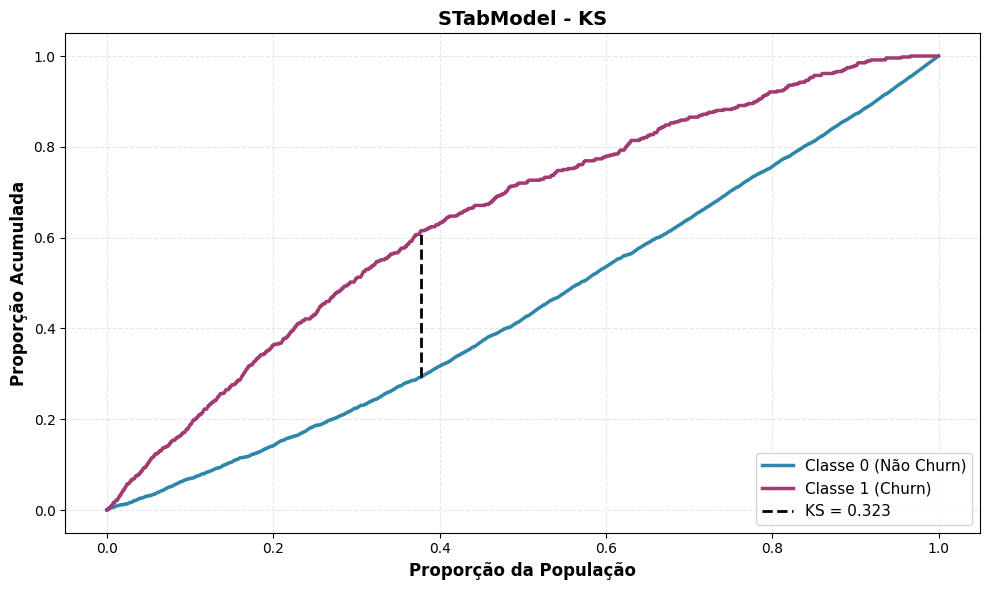

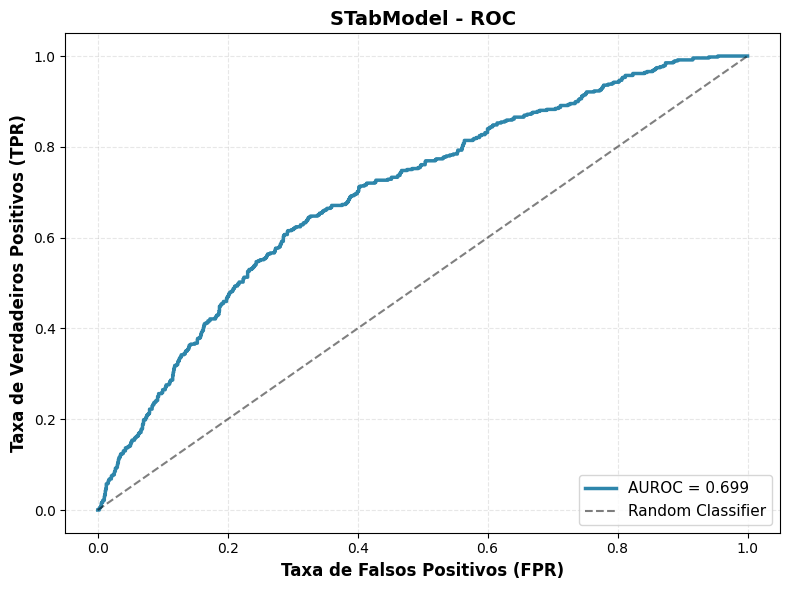

In [24]:
# 4. Experimento: STabModel (PyTorch) com hiperparâmetros
# ==========================================
print("🚀 Treinando STabModel (tuned + debug)...")

stab_config = {
    "d_model": 64,
    "depth": 4,
    "n_heads": 4,
    "ff_mult": 4,
    "ff_dropout": 0.2,
    "lr": 3e-4,
    "batch_size": 256,
    "epochs": 40,
    "max_fail": 10,
    "pooling": "mean",

    # DEBUG
    "verbose": True,
    "log_every": 10,        # print a cada 10 batches
    "debug_shapes": True,   # imprime shapes internos (1º batch por época)
    "debug_grads": False    # ativa norma do gradiente (deixa False pra não poluir/atrasar)
}

stab = STabModel(config=stab_config)
stab.build(input_dim=X_train.shape[1])

stab.train(X_train, y_train, X_val, y_val)

y_pred_stab = stab.predict_proba(X_test)
metrics_stab = calculate_all_metrics(y_test, y_pred_stab)

print_metrics("STabModel (Teste)", metrics_stab)
plot_ks_statistic(y_test, y_pred_stab, title="STabModel - KS")
plot_roc_curve(y_test, y_pred_stab, title="STabModel - ROC")


In [25]:
import os, json
from datetime import datetime
import matplotlib.pyplot as plt

# pasta
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# tag do experimento
now = datetime.now().strftime("%Y%m%d_%H%M%S")
exp_tag = (
    f"STab_{now}_"
    f"d{stab_config.get('d_model','NA')}_"
    f"L{stab_config.get('depth','NA')}_"
    f"H{stab_config.get('n_heads','NA')}_"
    f"lr{stab_config.get('lr','NA')}_"
    f"do{stab_config.get('ff_dropout','NA')}"
)
print("📁 Salvando:", exp_tag)

# paths
config_img = os.path.join(results_dir, f"{exp_tag}_CONFIG.png")
ks_path    = os.path.join(results_dir, f"{exp_tag}_KS.png")
roc_path   = os.path.join(results_dir, f"{exp_tag}_ROC.png")
meta_path  = os.path.join(results_dir, f"{exp_tag}_META.json")

# --- salva CONFIG como imagem ---
lines = [f"{k}: {v}" for k, v in sorted(stab_config.items())]
fig = plt.figure(figsize=(10, 6))
plt.axis("off")
fig.text(0.02, 0.98, exp_tag + "\n\n" + "\n".join(lines),
         va="top", ha="left", fontsize=12, family="monospace")
plt.savefig(config_img, dpi=200, bbox_inches="tight")
plt.close(fig)

# --- salva meta (config + métricas) ---
with open(meta_path, "w") as f:
    json.dump({"config": stab_config, "metrics_test": metrics_stab}, f, indent=2)

# --- salva KS e ROC (DO JEITO CERTO: dentro das funções) ---
plot_ks_statistic(y_test, y_pred_stab, output_path=ks_path, title=f"{exp_tag} - KS")
plot_roc_curve(y_test, y_pred_stab, output_path=roc_path, title=f"{exp_tag} - ROC")

print("✅ OK:")
print(" -", config_img)
print(" -", ks_path)
print(" -", roc_path)
print(" -", meta_path)


📁 Salvando: STab_20251217_030123_d64_L4_H4_lr0.0003_do0.2
📈 Gráfico KS salvo em: results/STab_20251217_030123_d64_L4_H4_lr0.0003_do0.2_KS.png
📈 Curva ROC salva em: results/STab_20251217_030123_d64_L4_H4_lr0.0003_do0.2_ROC.png
✅ OK:
 - results/STab_20251217_030123_d64_L4_H4_lr0.0003_do0.2_CONFIG.png
 - results/STab_20251217_030123_d64_L4_H4_lr0.0003_do0.2_KS.png
 - results/STab_20251217_030123_d64_L4_H4_lr0.0003_do0.2_ROC.png
 - results/STab_20251217_030123_d64_L4_H4_lr0.0003_do0.2_META.json
